## Imports and setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import stan
import pandas as pd
from scipy import stats
from scipy.special import softmax
from datetime import datetime
import time
import pickle 
import json
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

In [3]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

#### Prepare the trues

In [4]:
# They integrate to 1 
b0 = pd.read_csv('data/bottom_interpolated.csv', names=['gn1','density'],header=None )
l0 = pd.read_csv('data/light_interpolated.csv', names=['gn1','density'], header=None )
c0 = pd.read_csv('data/charm_interpolated.csv', names=['gn1','density'], header=None )

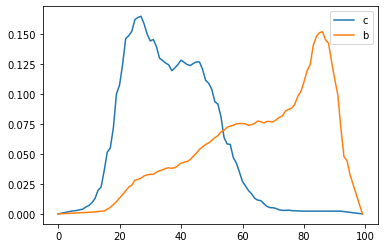

In [5]:
plt.plot(c0['density'], label='c')
plt.plot(b0['density'], label='b')
plt.legend()
plt.show()

In [10]:
# parameters to sonstruct the data
pi = [0.2,0.3,0.5]  # proportion expected for each class
                    # slot0: probability of class0 x class0 x class0 x class0
                    # slot1: probability of class1 x class1 x class1 x class1
                    # slot2: probability of class0 x class0 x class1 x class1 (in any order)
theta_prior = [[1.5,2], [5,2.5]]
classes = [1,2]  # which curves to compare, 0=light, 1=charm, 2 = bottom

## Data generating functions

##### Posterior GPxSM

In [11]:

def create_data_json_multithread(mytext = '', N = 300, pi = pi, theta_prior = theta_prior, m=15, classes = classes, mu_sigma = 0.2, sigma_sigma=0.1, mu_correlation=2.0, sigma_correlation=0.5, sigma_fixed=0.25, correlation_fixed=2.5, num_chains = 4, num_samples=300, num_threads = 18, myseed = 10, warmups = 1000, adapt=0.8, max_depth=10, save = False, key = ''):
    if key == '': 
        key = datetime.now().strftime("%d-%m-%Y.%H.%Mhs")
        suffix = ''
    else:
        suffix = key    
    print('Key:', key)
    # reshape true curves to m bins
    vec = np.linspace(0,99,m)
    myrows = [int(x) for x in vec]
    ltrue = l0.iloc[myrows]
    ctrue = c0.iloc[myrows]
    btrue = b0.iloc[myrows]
    ltrue.reset_index(drop=True, inplace=True)
    ctrue.reset_index(drop=True, inplace=True)
    btrue.reset_index(drop=True, inplace=True)
    curves = [ltrue, ctrue, btrue]    
    class0 = curves[classes[0]]
    class1 = curves[classes[1]]
    names = ['$j$','$c$','$b$']
    name0 = names[classes[0]]
    name1 = names[classes[1]]    
    classname = [name0, name1]    

    # determine start, stop and step of binning
    start = min(class0['gn1'])
    stop = max(class0['gn1'])
    m = len(ltrue)  # just to be sure we didn't screw it in thinning the lists
    step = (stop - start)/(m-1)
    midbins = [start+(i+1/2)*step for i in range(0,m-1)]
    edgebins = np.linspace(start,stop,m)
    # These are the steps and bins for the betas that are in [0,1] and should be translated to the real start/stop span
    start1 = 0
    stop1 = 1
    step1 = (stop1 - start1)/(m-1)
    midbins1 = [start1+(i+1/2)*step1 for i in range(0,m-1)]    
    
    # Distributions
    prior_distribution = [ [midbins, stats.beta.pdf(midbins1,theta_prior[0][0],theta_prior[0][1])], [midbins, stats.beta.pdf(midbins1,theta_prior[1][0],theta_prior[1][1])] ]
    true_distribution = [ [midbins, [ (class0.iloc[i]['density']+class0.iloc[i+1]['density'])/2 for i in range(m-1)] ] , [midbins, [ (class1.iloc[i]['density']+class1.iloc[i+1]['density'])/2 for i in range(m-1)] ] ]
    
    # Make probabilities sum 1
    for i in range(len(true_distribution)):
        tmp = sum(true_distribution[i][1])+0.0*(m-1)
        true_distribution[i][1] = [(x+0.0)/tmp for x in true_distribution[i][1]]

    for i in range(len(prior_distribution)):
        tmp = sum(prior_distribution[i][1])+0.0*(m-1)
        print(tmp)
        prior_distribution[i][1] = [(x+0.0)/tmp for x in prior_distribution[i][1]]
                                    # We ad 0.001 to avoid a "-inf" in log_prior that doe snot enter into c++ STAN code
    
    #print(prior_distribution[0][1])
          


    ####################################################
    np.random.seed(myseed)
    features = 4
    X = []  # 
    sampledclass0 = []
    sampledclass1 = []
    for i in range(N): 
        # class0 0000
        # class1 1111
        # class2 0011 (any order)
        myclass = list( stats.multinomial.rvs(n=1, p=pi) ).index(1)
        if myclass == 2:  # if class is 0011, then I should choose at random in which order are the jets, but always being 2 X c0 and 2 x c1
            z = np.random.randint(6)
            c01, c02, c11, c12 = list(np.random.choice(range(1,m), size = 1, p = true_distribution[0][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[0][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[1][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[1][1]))[0] 
            sampled = [ [c01,c02,c11,c12], [c01,c11,c02,c12], [c01,c11,c12,c02], [c11,c01,c02,c12],  [c11,c01,c12,c02], [c11,c12,c01,c02] ]
            sampledclass0 = sampledclass0 + [c01, c02]
            sampledclass1 = sampledclass1 + [c11, c12]
            X.append([myclass]+sampled[z])
        else:
            tmp = list(np.random.choice(range(1,m), size = features, p = true_distribution[myclass][1]) ) 
            if myclass == 0: sampledclass0 = sampledclass0 + tmp
            if myclass == 1: sampledclass1 = sampledclass1 + tmp
            X.append([myclass]+ tmp)     
    X=np.array(X)        
    X0 = pd.DataFrame(X, columns=['class','xn0','xn1','xn2','xn3'])
    
    # count how many of each jet class there are in each bin    
    tmp0 = []
    tmp1 = []
    for k in range(1,m):    
        tmp0.append([k,sampledclass0.count(k)])
        tmp1.append([k,sampledclass1.count(k)])
    tot0 = sum([x[1] for x in tmp0])
    tot1 = sum([x[1] for x in tmp1])
    sampledclass0 = [[x[0], x[1]/tot0] for x in tmp0]
    sampledclass1 = [[x[0], x[1]/tot1] for x in tmp1]

    plt.plot(true_distribution[0][0], true_distribution[0][1], '-.r', label='True '+name0+'-distribution')
    plt.plot(true_distribution[1][0], true_distribution[1][1], '-.b', label='True '+name1+'-distribution')
    plt.plot(prior_distribution[0][0], prior_distribution[0][1], ':r', label=name0+'-prior central-value')
    plt.plot(prior_distribution[1][0], prior_distribution[1][1], ':b', label=name1+'-prior central-value')
    plt.scatter(midbins, [x[1] for x in sampledclass0], color='red', s=15, label='Actual data for '+classname[0])
    plt.scatter(midbins, [x[1] for x in sampledclass1], color='blue', s=15, label='Actual data for '+classname[1])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(start,stop)
    plt.xlabel('ATLAS GN1')
    plt.yticks([])
    plt.title('True versus prior distributions')
    #if save == True:
    #    plt.savefig('results/'+key+'_prior-true-distributions_di-Higgs.png')
    plt.show()    
    
    # plot real data sampled
    #plt.hist(X0[X0['class']==0]['xn0'].tolist()+X0[X0['class']==0]['xn1'].tolist()+X0[X0['class']==0]['xn2'].tolist()+X0[X0['class']==0]['xn3'].tolist(), density = 1, bins=np.linspace(0.5,m-1+0.5,m), histtype='step', label=name0)
    #plt.hist(X0[X0['class']==1]['xn0'].tolist()+X0[X0['class']==1]['xn1'].tolist()+X0[X0['class']==1]['xn2'].tolist()+X0[X0['class']==1]['xn3'].tolist(), density = 1, bins=np.linspace(0.5,m-1+0.5,m), histtype='step', label=name1)
    #plt.scatter([x for x in range(m-1)], [x[1] for x in sampledclass0], color='red', s=15, label='Actual data for '+classname[0])
    #plt.scatter([x for x in range(m-1)], [x[1] for x in sampledclass1], color='blue', s=15, label='Actual data for '+classname[1])    
    #plt.title('Real data ('+str(N)+' events) stacked together by class')
    #plt.legend()
    #plt.xticks(range(1,m))
    #plt.show()

    #input('press any key to proceed')
    
    log_prior_distribution=[]
    for i in range(len(prior_distribution)):
        log_prior_distribution.append(np.log(prior_distribution[i][1]))

    # define mydata to run the model
    mydata = {'m': m, 'N': len(X), 'muj': list(log_prior_distribution[0]),  'mub': list(log_prior_distribution[1]), 'score': list(X[:,1:]), 'permutation_factor': 1/6.0, 'mu_sigma': mu_sigma, 'sigma_sigma': sigma_sigma, 'mu_correlation': mu_correlation, 'sigma_correlation': sigma_correlation, "sigma": sigma_fixed, "correlation": correlation_fixed}
    
    # write down the parameters of the run under the key name
    
    mydict = {'key': key, 'N':N, 'pi': pi, 'theta_prior': theta_prior, 'm': m, 'classes': classes, 'mu_sigma': mu_sigma, 'sigma_sigma': sigma_sigma, 'mu_correlation': mu_correlation,  'sigma_correlation': sigma_correlation, "sigma": sigma_fixed, "correlation": correlation_fixed, 'num_samples': num_samples, 'myseed': myseed,  'mytext': mytext, 'sampledclass0': sampledclass0, 'sampledclass1': sampledclass1, 'midbins': midbins, 'names': names , 'classname': classname, 'true_distribution': true_distribution, 'prior_distribution': prior_distribution, 'warmups': warmups, 'num_threads': num_threads, 'num_chains': num_chains, 'adapt': adapt}
    with open('results/'+key+'_dictionary.pkl', 'wb') as f:
        pickle.dump(mydict, f)

    # Write the bash scripts that runs stan from cmdstan
    replacements = [key,num_samples,warmups,num_chains,num_threads, myseed, adapt, max_depth]
    mybash = '''#!/usr/bin/bash
name="%s"
results_dir="models/notebooks/results"
if ls $results_dir/$name*csv 1> /dev/null 2>&1; then
        echo "File exsits!"
        exit 1
else
        echo 'ok seguimos'
        nsamples=%s
        nwarmups=%s
        nchains=%s
        nthreads=%s
        seed=%s
        adapt=%s
        max_depth=%s
        models/gp/gp1_no-correlation_parallel sample num_samples=$nsamples num_warmup=$nwarmups num_chains=$nchains adapt delta=$adapt algorithm=hmc engine=nuts max_depth=$max_depth data file=models/gp/$name.json num_threads=$nthreads output file="$results_dir"/"$name"-results.csv diagnostic_file="$results_dir"/"$name"-diagnostic.csv random seed=$seed
fi    
'''%tuple(replacements)
    f = open("../../gp"+suffix+".bash","w+")
    f.write(mybash)
    f.close()

    # write the json file with the data for this specific run
    with open('../gp/'+key+'.json', 'w') as fp:
        json.dump(mydata, fp, cls=NpEncoder)
    
    return mydata, key, X0

#### Dirichlet

In [12]:

def create_data_json_multitrhead_Dirichlet(mytext = '', N = 300, pi = pi, theta_prior = theta_prior, m=15, classes = classes, num_chains=5, num_samples=300, myseed = 10, save = True, tune0 = 48, tune1 = 48, num_threads = 18, warmups = 1000, adapt=0.8, max_depth=10, key = ''):
    if key == '': 
        key = datetime.now().strftime("%d-%m-%Y.%H.%MDr")
        suffix = ''
    else:
        suffix = key
    print('Key:', key)
    # reshape true curves to m bins
    vec = np.linspace(0,99,m)
    myrows = [int(x) for x in vec]
    ltrue = l0.iloc[myrows]
    ctrue = c0.iloc[myrows]
    btrue = b0.iloc[myrows]
    ltrue.reset_index(drop=True, inplace=True)
    ctrue.reset_index(drop=True, inplace=True)
    btrue.reset_index(drop=True, inplace=True)
    curves = [ltrue, ctrue, btrue]    
    class0 = curves[classes[0]]
    class1 = curves[classes[1]]
    names = ['$j$','$c$','$b$']
    name0 = names[classes[0]]
    name1 = names[classes[1]]    
    classname = [name0, name1]

    # determine start, stop and step of binning
    start = min(class0['gn1'])
    stop = max(class0['gn1'])
    m = len(ltrue)  # just to be sure we didn't screw it in thinning the lists
    step = (stop - start)/(m-1)
    midbins = [start+(i+1/2)*step for i in range(0,m-1)]
    edgebins = np.linspace(start,stop,m)
    # These are the steps and bins for the betas that are in [0,1] and should be translated to the real start/stop span
    start1 = 0
    stop1 = 1
    step1 = (stop1 - start1)/(m-1)
    midbins1 = [start1+(i+1/2)*step1 for i in range(0,m-1)]    
    
    # Distributions
    prior_distribution = [ [midbins, stats.beta.pdf(midbins1,theta_prior[0][0],theta_prior[0][1])], [midbins, stats.beta.pdf(midbins1,theta_prior[1][0],theta_prior[1][1])] ]
    true_distribution = [ [midbins, [ (class0.iloc[i]['density']+class0.iloc[i+1]['density'])/2 for i in range(m-1)] ] , [midbins, [ (class1.iloc[i]['density']+class1.iloc[i+1]['density'])/2 for i in range(m-1)] ] ]
    
    # Make probabilities sum 1
    for i in range(len(true_distribution)):
        tmp = sum(true_distribution[i][1])+0.0*(m-1)
        true_distribution[i][1] = [(x+0.0)/tmp for x in true_distribution[i][1]]

    for i in range(len(prior_distribution)):
        tmp = sum(prior_distribution[i][1])+0.0*(m-1)
        prior_distribution[i][1] = [(x+0.0)/tmp for x in prior_distribution[i][1]]
                                    # We ad 0.001 to avoid a "-inf" in log_prior that doe snot enter into c++ STAN code
    
    
    plt.plot(true_distribution[0][0], true_distribution[0][1], '-.r', label='True '+name0+'-distribution')
    plt.plot(true_distribution[1][0], true_distribution[1][1], '-.b', label='True '+name1+'-distribution')
    plt.plot(prior_distribution[0][0], prior_distribution[0][1], ':r', label=name0+'-prior central-value')
    plt.plot(prior_distribution[1][0], prior_distribution[1][1], ':b', label=name1+'-prior central-value')
    plt.legend()
    plt.xlim(start,stop)
    plt.xlabel('ATLAS GN1')
    plt.yticks([])
    plt.title('True versus prior distributions')
    #if save == True:
    #    plt.savefig('results/'+key+'_prior-true-distributions_di-Higgs.png')
    plt.show()    
    
    ####################################################
    np.random.seed(myseed)
    features = 4
    X = []  # 
    sampledclass0 = []
    sampledclass1 = []
    for i in range(N): 
        # class0 0000
        # class1 1111
        # class2 0011 (any order)
        myclass = list( stats.multinomial.rvs(n=1, p=pi) ).index(1)
        if myclass == 2:  # if class is 0011, then I should choose at random in which order are the jets, but always being 2 X c0 and 2 x c1
            z = np.random.randint(6)
            c01, c02, c11, c12 = list(np.random.choice(range(1,m), size = 1, p = true_distribution[0][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[0][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[1][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[1][1]))[0] 
            sampled = [ [c01,c02,c11,c12], [c01,c11,c02,c12], [c01,c11,c12,c02], [c11,c01,c02,c12],  [c11,c01,c12,c02], [c11,c12,c01,c02] ]
            sampledclass0 = sampledclass0 + [c01, c02]
            sampledclass1 = sampledclass1 + [c11, c12]
            X.append([myclass]+sampled[z])
        else:
            tmp = list(np.random.choice(range(1,m), size = features, p = true_distribution[myclass][1]) ) 
            if myclass == 0: sampledclass0 = sampledclass0 + tmp
            if myclass == 1: sampledclass1 = sampledclass1 + tmp
            X.append([myclass]+ tmp)        
    X=np.array(X)        
    X0 = pd.DataFrame(X, columns=['class','xn0','xn1','xn2','xn3'])
    
    # count how many of each jet class there are in each bin
    tmp0 = []
    tmp1 = []
    for k in range(1,m):    
        tmp0.append([k,sampledclass0.count(k)])
        tmp1.append([k,sampledclass1.count(k)])
    tot0 = sum([x[1] for x in tmp0])
    tot1 = sum([x[1] for x in tmp1])
    sampledclass0 = [[x[0], x[1]/tot0] for x in tmp0]
    sampledclass1 = [[x[0], x[1]/tot1] for x in tmp1]
    
    # plot real data sampled
    plt.hist(X0[X0['class']==0]['xn0'].tolist()+X0[X0['class']==0]['xn1'].tolist()+X0[X0['class']==0]['xn2'].tolist()+X0[X0['class']==0]['xn3'].tolist(), density = 1, bins=np.linspace(0.5,m-1+0.5,m), histtype='step', label=name0)
    plt.hist(X0[X0['class']==1]['xn0'].tolist()+X0[X0['class']==1]['xn1'].tolist()+X0[X0['class']==1]['xn2'].tolist()+X0[X0['class']==1]['xn3'].tolist(), density = 1, bins=np.linspace(0.5,m-1+0.5,m), histtype='step', label=name1)
    plt.title('Real data ('+str(N)+' events) stacked together by class')
    plt.xticks(range(1,m))
    plt.show()
    
    log_prior_distribution=[]
    for i in range(len(prior_distribution)):
        log_prior_distribution.append(np.log(prior_distribution[i][1]))
    

    
    # convert variables for Dirichlet alphas
    mean0 = prior_distribution[0][1]
    #print('mean0:', mean0)
    mean1 = prior_distribution[1][1]
    alpha0 =[tune0*mean0[i] for i in range(len(mean0))]
    alpha1 =[tune1*mean1[i] for i in range(len(mean1))]
    
    #mydata = {'m': m, 'N': len(X), 'alpha0': alpha0,  'alpha1': alpha1, 'score1': list(X[:,1]), 'score2': list(X[:,2]), 'score3': list(X[:,3]), 'score4': list(X[:,4]), 'permutation_factor': 1/6.0}
    # below for Manu's model
    mydata = {'m': m, 'N': len(X), 'muj': mean0,  'mub': mean1, 'sigma0': tune0, 'sigma1': tune1, 'score': list(X[:,1:]), 'permutation_factor': 1/6.0}

    #if mytext == '':
    #    mytext = input('Enter \'n\' to stop here, or enter a text to describe the current run. We\'ll save this test together with the run.')
    #    if mytext == 'n':
    #        return 0


    mydict = {'key': key, 'N':N, 'pi': pi, 'theta_prior': theta_prior, 'm': m, 'classes': classes, 'num_chains': num_chains, 'num_samples': num_samples, 'myseed': myseed,  'mytext': mytext, 'sampledclass0': sampledclass0, 'sampledclass1': sampledclass1, 'midbins': midbins, 'names': names , 'classname': classname, 'true_distribution': true_distribution, 'prior_distribution': prior_distribution,  'num_threads': num_threads, 'warmups': warmups , 'adapt': adapt, 'max_depth': max_depth }
    with open('results/'+key+'_dictionary.pkl', 'wb') as f:
        pickle.dump(mydict, f)    

    # Write the bash scripts that runs stan from cmdstan
    replacements = [key,num_samples,warmups,num_chains,num_threads, myseed, adapt, max_depth]
    mybash = '''#!/usr/bin/bash
name="%s"
nsamples=%s
nwarmups=%s
nchains=%s
nthreads=%s
seed=%s
adapt=%s
max_depth=%s
models/dirichlet/dirichlet sample num_samples=$nsamples num_warmup=$nwarmups num_chains=$nchains adapt delta=$adapt algorithm=hmc engine=nuts max_depth=$max_depth data file=models/dirichlet/$name.json num_threads=$nthreads output file=models/notebooks/results/"$name"-results.csv diagnostic_file=models/notebooks/results/"$name"-diagnostic.csv random seed=$seed
'''%tuple(replacements)
    f = open("../../dirichlet"+suffix+".bash","w+")
    f.write(mybash)
    f.close()

    # write the json file with the data for this specific run
    with open('../dirichlet/'+key+'.json', 'w') as fp:
        json.dump(mydata, fp, cls=NpEncoder)
    
    return mydata, key    
    

#### Unimode

In [13]:

def create_data_json_multithread_unimode(mytext = '', N = 100, pi = pi, theta_prior = theta_prior, m=15, classes = classes, mu_sigma = 0.2, sigma_sigma=0.1, mu_correlation=2.0, sigma_correlation=0.5, sigma_fixed=0.25, correlation_fixed=2.5, num_chains = 4, num_samples=300, num_threads = 18, myseed = 10, warmups = 500, adapt=0.8, max_depth=10, save = False, key = ''):
    if key == '': 
        key = datetime.now().strftime("%d-%m-%Y.%H.%MUM")
        suffix = ''
    else:
        suffix = key    
    print('Key:', key)
    # reshape true curves to m bins
    vec = np.linspace(0,99,m)
    myrows = [int(x) for x in vec]
    ltrue = l0.iloc[myrows]
    ctrue = c0.iloc[myrows]
    btrue = b0.iloc[myrows]
    ltrue.reset_index(drop=True, inplace=True)
    ctrue.reset_index(drop=True, inplace=True)
    btrue.reset_index(drop=True, inplace=True)

    
    curves = [ltrue, ctrue, btrue]    
    class0 = curves[classes[0]]
    class1 = curves[classes[1]]
    names = ['$j$','$c$','$b$']
    name0 = names[classes[0]]
    name1 = names[classes[1]]    
    classname = [name0, name1]    

    
    # determine start, stop and step of binning
    start = min(class0['gn1'])
    stop = max(class0['gn1'])
    m = len(ltrue)  # just to be sure we didn't screw it in thinning the lists
    step = (stop - start)/(m-1)
    midbins = [start+(i+1/2)*step for i in range(0,m-1)]
    edgebins = np.linspace(start,stop,m)
    # These are the steps and bins for the betas that are in [0,1] and should be translated to the real start/stop span
    start1 = 0
    stop1 = 1
    step1 = (stop1 - start1)/(m-1)
    midbins1 = [start1+(i+1/2)*step1 for i in range(0,m-1)]    
    
    # Distributions
    prior_distribution = [ [midbins, stats.beta.pdf(midbins1,theta_prior[0][0],theta_prior[0][1])], [midbins, stats.beta.pdf(midbins1,theta_prior[1][0],theta_prior[1][1])] ]
    true_distribution = [ [midbins, [ (class0.iloc[i]['density']+class0.iloc[i+1]['density'])/2 for i in range(m-1)] ] , [midbins, [ (class1.iloc[i]['density']+class1.iloc[i+1]['density'])/2 for i in range(m-1)] ] ]
    
    # Make probabilities sum 1
    for i in range(len(true_distribution)):
        tmp = sum(true_distribution[i][1])+0.0*(m-1)
        true_distribution[i][1] = [(x+0.0)/tmp for x in true_distribution[i][1]]

    for i in range(len(prior_distribution)):
        tmp = sum(prior_distribution[i][1])+0.0*(m-1)
        print(tmp)
        prior_distribution[i][1] = [(x+0.0)/tmp for x in prior_distribution[i][1]]
                                    # We ad 0.001 to avoid a "-inf" in log_prior that doe snot enter into c++ STAN code
    
    print(prior_distribution[0][1])
          
    plt.plot(true_distribution[0][0], true_distribution[0][1], '-.r', label='True '+name0+'-distribution')
    plt.plot(true_distribution[1][0], true_distribution[1][1], '-.b', label='True '+name1+'-distribution')
    plt.plot(prior_distribution[0][0], prior_distribution[0][1], ':r', label=name0+'-prior central-value')
    plt.plot(prior_distribution[1][0], prior_distribution[1][1], ':b', label=name1+'-prior central-value')
    plt.legend()
    plt.xlim(start,stop)
    plt.xlabel('ATLAS GN1')
    plt.yticks([])
    plt.title('True versus prior distributions')
    #if save == True:
    #    plt.savefig('results/'+key+'_prior-true-distributions_di-Higgs.png')
    plt.show()    

    ####################################################
    np.random.seed(myseed)
    features = 4
    X = []  # 
    sampledclass0 = []
    sampledclass1 = []
    for i in range(N): 
        # class0 0000
        # class1 1111
        # class2 0011 (any order)
        myclass = list( stats.multinomial.rvs(n=1, p=pi) ).index(1)
        if myclass == 2:  # if class is 0011, then I should choose at random in which order are the jets, but always being 2 X c0 and 2 x c1
            z = np.random.randint(6)
            c01, c02, c11, c12 = list(np.random.choice(range(1,m), size = 1, p = true_distribution[0][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[0][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[1][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[1][1]))[0] 
            sampled = [ [c01,c02,c11,c12], [c01,c11,c02,c12], [c01,c11,c12,c02], [c11,c01,c02,c12],  [c11,c01,c12,c02], [c11,c12,c01,c02] ]
            sampledclass0 = sampledclass0 + [c01, c02]
            sampledclass1 = sampledclass1 + [c11, c12]
            X.append([myclass]+sampled[z])
        else:
            tmp = list(np.random.choice(range(1,m), size = features, p = true_distribution[myclass][1]) ) 
            if myclass == 0: sampledclass0 = sampledclass0 + tmp
            if myclass == 1: sampledclass1 = sampledclass1 + tmp
            X.append([myclass]+ tmp)     
    X=np.array(X)        
    X0 = pd.DataFrame(X, columns=['class','xn0','xn1','xn2','xn3'])
    
    # count how many of each jet class there are in each bin    
    tmp0 = []
    tmp1 = []
    for k in range(1,m):    
        tmp0.append([k,sampledclass0.count(k)])
        tmp1.append([k,sampledclass1.count(k)])
    tot0 = sum([x[1] for x in tmp0])
    tot1 = sum([x[1] for x in tmp1])
    sampledclass0 = [[x[0], x[1]/tot0] for x in tmp0]
    sampledclass1 = [[x[0], x[1]/tot1] for x in tmp1]
    
    # plot real data sampled
    plt.hist(X0[X0['class']==0]['xn0'].tolist()+X0[X0['class']==0]['xn1'].tolist()+X0[X0['class']==0]['xn2'].tolist()+X0[X0['class']==0]['xn3'].tolist(), density = 1, bins=np.linspace(0.5,m-1+0.5,m), histtype='step', label=name0)
    plt.hist(X0[X0['class']==1]['xn0'].tolist()+X0[X0['class']==1]['xn1'].tolist()+X0[X0['class']==1]['xn2'].tolist()+X0[X0['class']==1]['xn3'].tolist(), density = 1, bins=np.linspace(0.5,m-1+0.5,m), histtype='step', label=name1)
    plt.title('Real data ('+str(N)+' events) stacked together by class')
    plt.xticks(range(1,m))
    plt.show()
    

    muj = list(true_distribution[0][1])
    mub = list(true_distribution[1][1])

  
    # define mydata to run the model
    mydata = {'m': m, 'N': len(X), 'muj': muj,  'mub': mub, 'score': list(X[:,1:]), 'permutation_factor': 1.0/6.0, 'mu_sigma': mu_sigma, 'sigma_sigma': sigma_sigma, 'mu_correlation': mu_correlation, 'sigma_correlation': sigma_correlation, "sigma": sigma_fixed, "correlation": correlation_fixed}
    
    # write down the parameters of the run under the key name
    
    mydict = {'key': key, 'N':N, 'pi': pi, 'theta_prior': theta_prior, 'm': m, 'classes': classes, 'mu_sigma': mu_sigma, 'sigma_sigma': sigma_sigma, 'mu_correlation': mu_correlation,  'sigma_correlation': sigma_correlation, "sigma": sigma_fixed, "correlation": correlation_fixed, 'num_samples': num_samples, 'myseed': myseed,  'mytext': mytext, 'sampledclass0': sampledclass0, 'sampledclass1': sampledclass1, 'midbins': midbins, 'names': names , 'classname': classname, 'true_distribution': true_distribution, 'prior_distribution': prior_distribution, 'warmups': warmups, 'num_threads': num_threads, 'num_chains': num_chains, 'adapt': adapt}
    with open('results/'+key+'_dictionary.pkl', 'wb') as f:
        pickle.dump(mydict, f)

    # Write the bash scripts that runs stan from cmdstan
    replacements = [key,num_samples,warmups,num_chains,num_threads, myseed, adapt, max_depth]
    mybash = '''#!/usr/bin/bash
name="%s"
results_dir="models/notebooks/results"
if ls $results_dir/$name*csv 1> /dev/null 2>&1; then
        echo "File exsits!"
        exit 1
else
        echo 'ok seguimos'
        nsamples=%s
        nwarmups=%s
        nchains=%s
        nthreads=%s
        seed=%s
        adapt=%s
        max_depth=%s
        models/unimode/unimode2_symmetric_Dirichtlet sample num_samples=$nsamples num_warmup=$nwarmups num_chains=$nchains adapt delta=$adapt algorithm=hmc engine=nuts max_depth=$max_depth data file=models/unimode/$name.json num_threads=$nthreads output file="$results_dir"/"$name"-results.csv diagnostic_file="$results_dir"/"$name"-diagnostic.csv random seed=$seed
fi    
'''%tuple(replacements)
    f = open("../../unimode"+suffix+".bash","w+")
    f.write(mybash)
    f.close()

    # write the json file with the data for this specific run
    with open('../unimode/'+key+'.json', 'w') as fp:
        json.dump(mydata, fp, cls=NpEncoder)
    
    return sampledclass0, sampledclass1,  muj, mub, X0, mydata, key

#### Point-estimate

In [14]:

def create_data_json_multithread_pointestimate(mytext = '', N = 100, pi = pi, theta_prior = theta_prior, m=15, classes = classes, w_j_mode=10, w_b_mode=20, mu_sigma = 0.2, sigma_sigma=0.1, mu_correlation=2.0, sigma_correlation=0.5, sigma_fixed=0.25, correlation_fixed=2.5, num_chains = 4, num_samples=300, num_threads = 18, myseed = 10, warmups = 500, adapt=0.8, max_depth=10, save = False):
    key = datetime.now().strftime("%d-%m-%Y.%H.%MPE")
    print('Key:', key)
    # reshape true curves to m bins
    vec = np.linspace(0,99,m)
    myrows = [int(x) for x in vec]
    ltrue = l0.iloc[myrows]
    ctrue = c0.iloc[myrows]
    btrue = b0.iloc[myrows]
    ltrue.reset_index(drop=True, inplace=True)
    ctrue.reset_index(drop=True, inplace=True)
    btrue.reset_index(drop=True, inplace=True)
    curves = [ltrue, ctrue, btrue]    
    class0 = curves[classes[0]]
    class1 = curves[classes[1]]
    names = ['$j$','$c$','$b$']
    name0 = names[classes[0]]
    name1 = names[classes[1]]    
    classname = [name0, name1]    

    # determine start, stop and step of binning
    start = min(class0['gn1'])
    stop = max(class0['gn1'])
    m = len(ltrue)  # just to be sure we didn't screw it in thinning the lists
    step = (stop - start)/(m-1)
    midbins = [start+(i+1/2)*step for i in range(0,m-1)]
    edgebins = np.linspace(start,stop,m)
    # These are the steps and bins for the betas that are in [0,1] and should be translated to the real start/stop span
    start1 = 0
    stop1 = 1
    step1 = (stop1 - start1)/(m-1)
    midbins1 = [start1+(i+1/2)*step1 for i in range(0,m-1)]    
    
    # Distributions
    prior_distribution = [ [midbins, stats.beta.pdf(midbins1,theta_prior[0][0],theta_prior[0][1])], [midbins, stats.beta.pdf(midbins1,theta_prior[1][0],theta_prior[1][1])] ]
    true_distribution = [ [midbins, [ (class0.iloc[i]['density']+class0.iloc[i+1]['density'])/2 for i in range(m-1)] ] , [midbins, [ (class1.iloc[i]['density']+class1.iloc[i+1]['density'])/2 for i in range(m-1)] ] ]
    
    # Make probabilities sum 1
    for i in range(len(true_distribution)):
        tmp = sum(true_distribution[i][1])+0.0*(m-1)
        true_distribution[i][1] = [(x+0.0)/tmp for x in true_distribution[i][1]]

    for i in range(len(prior_distribution)):
        tmp = sum(prior_distribution[i][1])+0.0*(m-1)
        print(tmp)
        prior_distribution[i][1] = [(x+0.0)/tmp for x in prior_distribution[i][1]]
                                    # We ad 0.001 to avoid a "-inf" in log_prior that doe snot enter into c++ STAN code
    
    print(prior_distribution[0][1])
          
    plt.plot(true_distribution[0][0], true_distribution[0][1], '-.r', label='True '+name0+'-distribution')
    plt.plot(true_distribution[1][0], true_distribution[1][1], '-.b', label='True '+name1+'-distribution')
    plt.plot(prior_distribution[0][0], prior_distribution[0][1], ':r', label=name0+'-prior central-value')
    plt.plot(prior_distribution[1][0], prior_distribution[1][1], ':b', label=name1+'-prior central-value')
    plt.legend()
    plt.xlim(start,stop)
    plt.xlabel('ATLAS GN1')
    plt.yticks([])
    plt.title('True versus prior distributions')
    #if save == True:
    #    plt.savefig('results/'+key+'_prior-true-distributions_di-Higgs.png')
    plt.show()    

    ####################################################
    np.random.seed(myseed)
    features = 4
    X = []  # 
    sampledclass0 = []
    sampledclass1 = []
    for i in range(N): 
        # class0 0000
        # class1 1111
        # class2 0011 (any order)
        myclass = list( stats.multinomial.rvs(n=1, p=pi) ).index(1)
        if myclass == 2:  # if class is 0011, then I should choose at random in which order are the jets, but always being 2 X c0 and 2 x c1
            z = np.random.randint(6)
            c01, c02, c11, c12 = list(np.random.choice(range(1,m), size = 1, p = true_distribution[0][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[0][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[1][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[1][1]))[0] 
            sampled = [ [c01,c02,c11,c12], [c01,c11,c02,c12], [c01,c11,c12,c02], [c11,c01,c02,c12],  [c11,c01,c12,c02], [c11,c12,c01,c02] ]
            sampledclass0 = sampledclass0 + [c01, c02]
            sampledclass1 = sampledclass1 + [c11, c12]
            X.append([myclass]+sampled[z])
        else:
            tmp = list(np.random.choice(range(1,m), size = features, p = true_distribution[myclass][1]) ) 
            if myclass == 0: sampledclass0 = sampledclass0 + tmp
            if myclass == 1: sampledclass1 = sampledclass1 + tmp
            X.append([myclass]+ tmp)     
    X=np.array(X)        
    X0 = pd.DataFrame(X, columns=['class','xn0','xn1','xn2','xn3'])
    
    # count how many of each jet class there are in each bin    
    tmp0 = []
    tmp1 = []
    for k in range(1,m):    
        tmp0.append([k,sampledclass0.count(k)])
        tmp1.append([k,sampledclass1.count(k)])
    tot0 = sum([x[1] for x in tmp0])
    tot1 = sum([x[1] for x in tmp1])
    sampledclass0 = [[x[0], x[1]/tot0] for x in tmp0]
    sampledclass1 = [[x[0], x[1]/tot1] for x in tmp1]
    
    # plot real data sampled
    plt.hist(X0[X0['class']==0]['xn0'].tolist()+X0[X0['class']==0]['xn1'].tolist()+X0[X0['class']==0]['xn2'].tolist()+X0[X0['class']==0]['xn3'].tolist(), density = 1, bins=np.linspace(0.5,m-1+0.5,m), histtype='step', label=name0)
    plt.hist(X0[X0['class']==1]['xn0'].tolist()+X0[X0['class']==1]['xn1'].tolist()+X0[X0['class']==1]['xn2'].tolist()+X0[X0['class']==1]['xn3'].tolist(), density = 1, bins=np.linspace(0.5,m-1+0.5,m), histtype='step', label=name1)
    plt.title('Real data ('+str(N)+' events) stacked together by class')
    plt.xticks(range(1,m))
    plt.show()
    

    # define mydata to run the model
    mydata = {'m': m, 'N': len(X), 'w_j_mode': w_j_mode,  'w_b_mode': w_b_mode, 'muj': list(prior_distribution[0][1]),  'mub': list(prior_distribution[1][1]), 'score': list(X[:,1:]), 'permutation_factor': 1.0/6.0, 'mu_sigma': mu_sigma, 'sigma_sigma': sigma_sigma, 'mu_correlation': mu_correlation, 'sigma_correlation': sigma_correlation, "sigma": sigma_fixed, "correlation": correlation_fixed}
    
    # write down the parameters of the run under the key name
    
    mydict = {'key': key, 'N':N, 'pi': pi, 'theta_prior': theta_prior, 'm': m, 'classes': classes, 'mu_sigma': mu_sigma, 'sigma_sigma': sigma_sigma, 'mu_correlation': mu_correlation,  'sigma_correlation': sigma_correlation, "sigma": sigma_fixed, "correlation": correlation_fixed, 'num_samples': num_samples, 'myseed': myseed,  'mytext': mytext, 'sampledclass0': sampledclass0, 'sampledclass1': sampledclass1, 'midbins': midbins, 'names': names , 'classname': classname, 'true_distribution': true_distribution, 'prior_distribution': prior_distribution, 'warmups': warmups, 'num_threads': num_threads, 'num_chains': num_chains, 'adapt': adapt}
    with open('results/'+key+'_dictionary.pkl', 'wb') as f:
        pickle.dump(mydict, f)

    # Write the bash scripts that runs stan from cmdstan
    replacements = [key,num_samples,warmups,num_chains,num_threads, myseed, adapt, max_depth]
    mybash = '''#!/usr/bin/bash
name="%s"
results_dir="models/notebooks/results"
if ls $results_dir/$name*csv 1> /dev/null 2>&1; then
        echo "File exsits!"
        exit 1
else
        echo 'ok seguimos'
        nsamples=%s
        nwarmups=%s
        nchains=%s
        nthreads=%s
        seed=%s
        adapt=%s
        max_depth=%s
        models/point-estimate/point-estimate sample num_samples=$nsamples num_warmup=$nwarmups num_chains=$nchains adapt delta=$adapt algorithm=hmc engine=nuts max_depth=$max_depth data file=models/point-estimate/$name.json num_threads=$nthreads output file="$results_dir"/"$name"-results.csv diagnostic_file="$results_dir"/"$name"-diagnostic.csv random seed=$seed
fi    
'''%tuple(replacements)
    f = open("../../point-estimate.bash","w+")
    f.write(mybash)
    f.close()

    # write the json file with the data for this specific run
    with open('../point-estimate/'+key+'.json', 'w') as fp:
        json.dump(mydata, fp, cls=NpEncoder)
    
    return mydata, key

In [15]:

def create_data_json_multithread_pointestimatefull(mytext = '', N = 100, pi = pi, theta_prior = theta_prior, m=15, classes = classes, w_j_mode=[8,9,10,11], w_b_mode=[18,19,20,21], mu_sigma = 0.2, sigma_sigma=0.1, mu_correlation=2.0, sigma_correlation=0.5, sigma_fixed=0.25, correlation_fixed=2.5, num_chains = 4, num_samples=300, num_threads = 18, myseed = 10, warmups = 500, adapt=0.8, max_depth=10, save = False):
    key = datetime.now().strftime("%d-%m-%Y.%H.%MPE")
    print('Key:', key)
    # reshape true curves to m bins
    vec = np.linspace(0,99,m)
    myrows = [int(x) for x in vec]
    ltrue = l0.iloc[myrows]
    ctrue = c0.iloc[myrows]
    btrue = b0.iloc[myrows]
    ltrue.reset_index(drop=True, inplace=True)
    ctrue.reset_index(drop=True, inplace=True)
    btrue.reset_index(drop=True, inplace=True)
    curves = [ltrue, ctrue, btrue]    
    class0 = curves[classes[0]]
    class1 = curves[classes[1]]
    names = ['$j$','$c$','$b$']
    name0 = names[classes[0]]
    name1 = names[classes[1]]    
    classname = [name0, name1]    

    # determine start, stop and step of binning
    start = min(class0['gn1'])
    stop = max(class0['gn1'])
    m = len(ltrue)  # just to be sure we didn't screw it in thinning the lists
    step = (stop - start)/(m-1)
    midbins = [start+(i+1/2)*step for i in range(0,m-1)]
    edgebins = np.linspace(start,stop,m)
    # These are the steps and bins for the betas that are in [0,1] and should be translated to the real start/stop span
    start1 = 0
    stop1 = 1
    step1 = (stop1 - start1)/(m-1)
    midbins1 = [start1+(i+1/2)*step1 for i in range(0,m-1)]    
    
    # Distributions
    prior_distribution = [ [midbins, stats.beta.pdf(midbins1,theta_prior[0][0],theta_prior[0][1])], [midbins, stats.beta.pdf(midbins1,theta_prior[1][0],theta_prior[1][1])] ]
    true_distribution = [ [midbins, [ (class0.iloc[i]['density']+class0.iloc[i+1]['density'])/2 for i in range(m-1)] ] , [midbins, [ (class1.iloc[i]['density']+class1.iloc[i+1]['density'])/2 for i in range(m-1)] ] ]
    
    # Make probabilities sum 1
    for i in range(len(true_distribution)):
        tmp = sum(true_distribution[i][1])+0.0*(m-1)
        true_distribution[i][1] = [(x+0.0)/tmp for x in true_distribution[i][1]]

    for i in range(len(prior_distribution)):
        tmp = sum(prior_distribution[i][1])+0.0*(m-1)
        print(tmp)
        prior_distribution[i][1] = [(x+0.0)/tmp for x in prior_distribution[i][1]]
                                    # We ad 0.001 to avoid a "-inf" in log_prior that doe snot enter into c++ STAN code
    
    print(prior_distribution[0][1])
          
    plt.plot(true_distribution[0][0], true_distribution[0][1], '-.r', label='True '+name0+'-distribution')
    plt.plot(true_distribution[1][0], true_distribution[1][1], '-.b', label='True '+name1+'-distribution')
    plt.plot(prior_distribution[0][0], prior_distribution[0][1], ':r', label=name0+'-prior central-value')
    plt.plot(prior_distribution[1][0], prior_distribution[1][1], ':b', label=name1+'-prior central-value')
    plt.legend()
    plt.xlim(start,stop)
    plt.xlabel('ATLAS GN1')
    plt.yticks([])
    plt.title('True versus prior distributions')
    #if save == True:
    #    plt.savefig('results/'+key+'_prior-true-distributions_di-Higgs.png')
    plt.show()    

    ####################################################
    np.random.seed(myseed)
    features = 4
    X = []  # 
    sampledclass0 = []
    sampledclass1 = []
    for i in range(N): 
        # class0 0000
        # class1 1111
        # class2 0011 (any order)
        myclass = list( stats.multinomial.rvs(n=1, p=pi) ).index(1)
        if myclass == 2:  # if class is 0011, then I should choose at random in which order are the jets, but always being 2 X c0 and 2 x c1
            z = np.random.randint(6)
            c01, c02, c11, c12 = list(np.random.choice(range(1,m), size = 1, p = true_distribution[0][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[0][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[1][1]))[0], list(np.random.choice(range(1,m), size = 1, p = true_distribution[1][1]))[0] 
            sampled = [ [c01,c02,c11,c12], [c01,c11,c02,c12], [c01,c11,c12,c02], [c11,c01,c02,c12],  [c11,c01,c12,c02], [c11,c12,c01,c02] ]
            sampledclass0 = sampledclass0 + [c01, c02]
            sampledclass1 = sampledclass1 + [c11, c12]
            X.append([myclass]+sampled[z])
        else:
            tmp = list(np.random.choice(range(1,m), size = features, p = true_distribution[myclass][1]) ) 
            if myclass == 0: sampledclass0 = sampledclass0 + tmp
            if myclass == 1: sampledclass1 = sampledclass1 + tmp
            X.append([myclass]+ tmp)     
    X=np.array(X)        
    X0 = pd.DataFrame(X, columns=['class','xn0','xn1','xn2','xn3'])
    
    # count how many of each jet class there are in each bin    
    tmp0 = []
    tmp1 = []
    for k in range(1,m):    
        tmp0.append([k,sampledclass0.count(k)])
        tmp1.append([k,sampledclass1.count(k)])
    tot0 = sum([x[1] for x in tmp0])
    tot1 = sum([x[1] for x in tmp1])
    sampledclass0 = [[x[0], x[1]/tot0] for x in tmp0]
    sampledclass1 = [[x[0], x[1]/tot1] for x in tmp1]
    
    # plot real data sampled
    plt.hist(X0[X0['class']==0]['xn0'].tolist()+X0[X0['class']==0]['xn1'].tolist()+X0[X0['class']==0]['xn2'].tolist()+X0[X0['class']==0]['xn3'].tolist(), density = 1, bins=np.linspace(0.5,m-1+0.5,m), histtype='step', label=name0)
    plt.hist(X0[X0['class']==1]['xn0'].tolist()+X0[X0['class']==1]['xn1'].tolist()+X0[X0['class']==1]['xn2'].tolist()+X0[X0['class']==1]['xn3'].tolist(), density = 1, bins=np.linspace(0.5,m-1+0.5,m), histtype='step', label=name1)
    plt.title('Real data ('+str(N)+' events) stacked together by class')
    plt.xticks(range(1,m))
    plt.show()
    

    # define mydata to run the model
    mydata = []
    for w_b in w_b_mode:
        for w_j in w_j_mode:
            mydata.append([w_j, w_b, {'m': m, 'N': len(X), 'w_j_mode': w_j,  'w_b_mode': w_b, 'muj': list(prior_distribution[0][1]),  'mub': list(prior_distribution[1][1]), 'score': list(X[:,1:]), 'permutation_factor': 1.0/6.0, 'mu_sigma': mu_sigma, 'sigma_sigma': sigma_sigma, 'mu_correlation': mu_correlation, 'sigma_correlation': sigma_correlation, "sigma": sigma_fixed, "correlation": correlation_fixed}])
    
    # write down the parameters of the run under the key name
    
    mydict = {'key': key, 'N':N, 'pi': pi, 'theta_prior': theta_prior, 'm': m, 'classes': classes, 'w_j_mode': w_j_mode, 'w_b_mode': w_b_mode, 'mu_sigma': mu_sigma, 'sigma_sigma': sigma_sigma, 'mu_correlation': mu_correlation,  'sigma_correlation': sigma_correlation, "sigma": sigma_fixed, "correlation": correlation_fixed, 'num_samples': num_samples, 'myseed': myseed,  'mytext': mytext, 'sampledclass0': sampledclass0, 'sampledclass1': sampledclass1, 'midbins': midbins, 'names': names , 'classname': classname, 'true_distribution': true_distribution, 'prior_distribution': prior_distribution, 'warmups': warmups, 'num_threads': num_threads, 'num_chains': num_chains}
    with open('results/'+key+'_dictionary.pkl', 'wb') as f:
        pickle.dump(mydict, f)

    # Write the bash scripts that runs stan from cmdstan
    replacements = [key,num_samples,warmups,num_chains,num_threads, myseed, adapt, max_depth]
    mybash = '''#!/usr/bin/bash
name="%s"
results_dir="models/notebooks/results"
if ls $results_dir/$name*csv 1> /dev/null 2>&1; then
        echo "File exsits!"
        exit 1
else
        echo 'ok seguimos'
        nsamples=%s
        nwarmups=%s
        nchains=%s
        nthreads=%s
        seed=%s
        adapt=%s
        max_depth=%s
    '''%tuple(replacements)        

    for w_b in w_b_mode:
        for w_j in w_j_mode:
            mybash = mybash + '''
            models/point-estimate/point-estimate sample num_samples=$nsamples num_warmup=$nwarmups num_chains=$nchains adapt delta=$adapt algorithm=hmc engine=nuts max_depth=$max_depth data file=models/point-estimate/$name.%s.%s.json num_threads=$nthreads output file="$results_dir"/"$name".%s.%s-results.csv random seed=$seed'''%(str(w_j), str(w_b), str(w_j), str(w_b))
    
    mybash=mybash+'''
    fi'''

    f = open("../../point-estimate.bash","w+")
    f.write(mybash)
    f.close()

    for mydata_tmp in mydata:
        w_j = mydata_tmp[0]
        w_b = mydata_tmp[1]
        # write the json file with the data for this specific run
        with open('../point-estimate/'+key+'.'+str(w_j)+'.'+str(w_b)+'.json', 'w') as fp:
            json.dump(mydata_tmp[2], fp, cls=NpEncoder)
    
    return mydata, key

## Generate data

#### GPxSM

Key: 24-02-2024.20.17hs
23.99956436398996
24.018739886356666


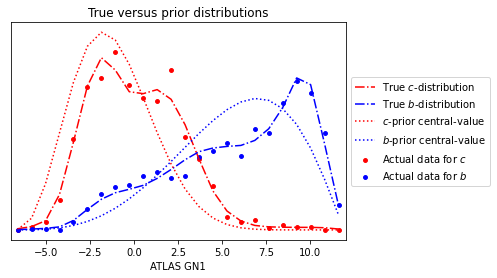

In [25]:
#for tt in range(30):
#    tt0 = str(tt)
#    if len(tt0)<2: tt0 = '0'+tt0
#    key = 'test-GP-switching-250events-seed_'+tt0
#    print(key)
#    mydata, key, X0 = create_data_json_multithread(mytext = 'xxxx ', N = 250, pi = pi, theta_prior = [[3*1.5,6*1.7], [5*.9,2.5*0.9]], m=25, classes = [1,2], mu_sigma = 0.3, sigma_sigma=0.05, mu_correlation=3.0, sigma_correlation=0.25, sigma_fixed=0.25,  correlation_fixed=3.0, myseed=tt, num_chains=4, num_samples=300, warmups=200,  adapt=0.8, max_depth=15, num_threads = 18, key=key)

mydata, key, X0 = create_data_json_multithread(mytext = 'xxxx ', N = 500, pi = pi, theta_prior = [[3*1.5,6*1.7], [5*.9,2.5*0.9]], m=25, classes = [1,2], mu_sigma = 0.3, sigma_sigma=0.05, mu_correlation=3.0, sigma_correlation=0.25, sigma_fixed=0.25,  correlation_fixed=3.0, myseed=30, num_chains=4, num_samples=1000, warmups=1000,  adapt=0.8, max_depth=15, num_threads = 18)

#### Dirichlet

Key: 28-02-2024.22.48Dr


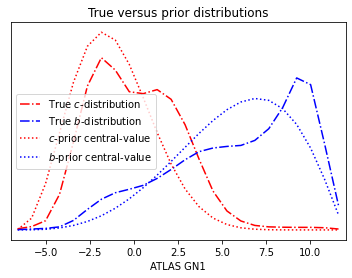

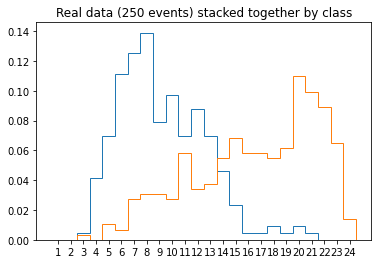

In [48]:
#for tt in range(30):
#    tt0 = str(tt)
#    if len(tt0)<2: tt0 = '0'+tt0
#    key = 'test-Dirichlet-switching-250events-seed_'+tt0
#    print(key)
#    mydata, key0 = create_data_json_multitrhead_Dirichlet(mytext = 'xxx', N = 250, pi = pi, theta_prior = [[3*1.5,6*1.7], [5*.9,2.5*0.9]], m=25, classes = [1,2], myseed=tt, num_chains=4, tune0=50, tune1=50, num_samples=1000, warmups=1000,  adapt=0.9, max_depth=13, num_threads = 18,  key = key);

mydata, key0 = create_data_json_multitrhead_Dirichlet(mytext = 'xxx', N = 250, pi = pi, theta_prior = [[3*1.5,6*1.7], [5*.9,2.5*0.9]], m=25, classes = [1,2], myseed=30, num_chains=4, tune0=50, tune1=50, num_samples=2000, warmups=2000,  adapt=0.9, max_depth=13, num_threads = 18);    

#### Unimode

Key: 04-03-2024.00.23UM
23.99956436398996
24.018739886356666
[0.00026470544176951426, 0.008297401294964117, 0.032641295192780063, 0.06837812666816664, 0.10401734016817481, 0.12935786407863148, 0.13921637387261152, 0.13369348065298536, 0.11656317934942335, 0.09314547474043704, 0.06851359219794467, 0.046404284674850006, 0.028850191368241934, 0.016355102213184123, 0.008363512261517549, 0.0037962830130822997, 0.0014938292173586592, 0.0004920163931762154, 0.00012852313609258405, 2.4390448591374603e-05, 2.878114339025749e-06, 1.5386017106388004e-07, 1.641428304961554e-09, 7.79480184558857e-14]


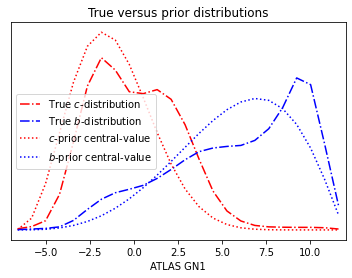

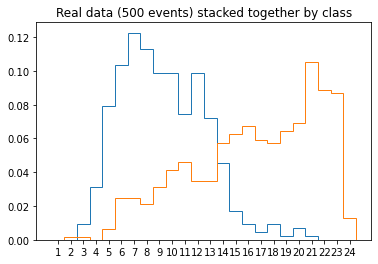

In [19]:
#for tt in range(30):
#    tt0 = str(tt)
#    if len(tt0)<2: tt0 = '0'+tt0
#    key = 'test-Unimode-switching-squeezed-bump-250events-seed_'+tt0
#    print(key)
#    sampledclass0, sampledclass1, muj, mub, X0, mydata, key0 = create_data_json_multithread_unimode(mytext = 'xxx', N = 250, pi = pi, theta_prior = [[3*1.5,6*1.7], [5*.9,2.5*0.9]], m=25, classes = [1,2], mu_sigma = 0.3, sigma_sigma=0.05, mu_correlation=3.0, sigma_correlation=0.25, sigma_fixed=0.25,  correlation_fixed=2.5, myseed=tt, num_chains=4, num_samples=1000, warmups=1000,  adapt=0.9, max_depth=15, num_threads = 18, key = key)

sampledclass0, sampledclass1, muj, mub, X0, mydata, key0 = create_data_json_multithread_unimode(mytext = 'xxx', N = 500, pi = pi, theta_prior = [[3*1.5,6*1.7], [5*.9,2.5*0.9]], m=25, classes = [1,2], mu_sigma = 0.3, sigma_sigma=0.05, mu_correlation=3.0, sigma_correlation=0.25, sigma_fixed=0.25,  correlation_fixed=2.5, myseed=30, num_chains=4, num_samples=1000, warmups=2500,  adapt=0.9, max_depth=15, num_threads = 18)

#### Point-Estimate

Key: 29-02-2024.23.30PE
23.99956436398996
24.018739886356666
[0.00026470544176951426, 0.008297401294964117, 0.032641295192780063, 0.06837812666816664, 0.10401734016817481, 0.12935786407863148, 0.13921637387261152, 0.13369348065298536, 0.11656317934942335, 0.09314547474043704, 0.06851359219794467, 0.046404284674850006, 0.028850191368241934, 0.016355102213184123, 0.008363512261517549, 0.0037962830130822997, 0.0014938292173586592, 0.0004920163931762154, 0.00012852313609258405, 2.4390448591374603e-05, 2.878114339025749e-06, 1.5386017106388004e-07, 1.641428304961554e-09, 7.79480184558857e-14]


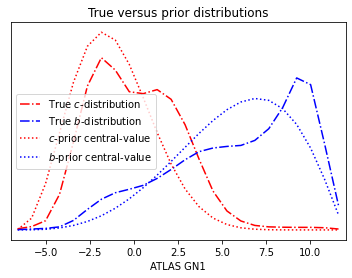

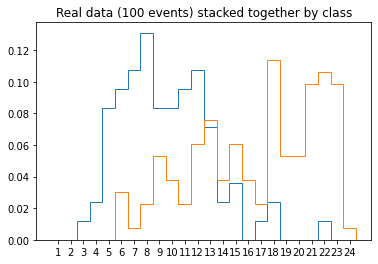

In [57]:
# TIP:
# If the max for the mean density is e.g. in w_j_mode[8], then one should put here w_j_mode=9.  And similarly for w_b_mode.  Just add 1 to what comes from the max mean density.
# I have verified this on the field: I've checked that the maxima in PE is at the same bin where the maximum in Unimodal
mydata, key = create_data_json_multithread_pointestimate(mytext = 'bla bla', N = 100, pi = pi, theta_prior = [[3*1.5,6*1.7], [5*.9,2.5*0.9]], m=25, classes = [1,2], w_j_mode=8, w_b_mode=21, myseed=10000, num_chains=4, num_samples=1000, warmups=1000,  adapt=0.9, max_depth=13, num_threads = 18)

Key: 28-02-2024.23.10PE
23.99956436398996
24.018739886356666
[0.00026470544176951426, 0.008297401294964117, 0.032641295192780063, 0.06837812666816664, 0.10401734016817481, 0.12935786407863148, 0.13921637387261152, 0.13369348065298536, 0.11656317934942335, 0.09314547474043704, 0.06851359219794467, 0.046404284674850006, 0.028850191368241934, 0.016355102213184123, 0.008363512261517549, 0.0037962830130822997, 0.0014938292173586592, 0.0004920163931762154, 0.00012852313609258405, 2.4390448591374603e-05, 2.878114339025749e-06, 1.5386017106388004e-07, 1.641428304961554e-09, 7.79480184558857e-14]


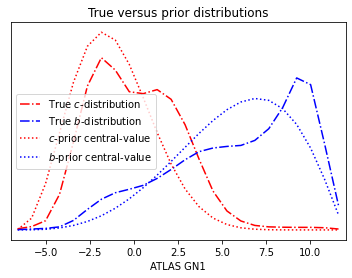

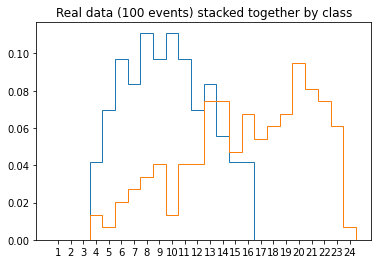

In [52]:
mydata, key = create_data_json_multithread_pointestimatefull(mytext = 'bla bla', N = 100, pi = pi, theta_prior = [[3*1.5,6*1.7], [5*.9,2.5*0.9]], m=25, classes = [1,2], w_j_mode=[6,7,8], w_b_mode=[20,21,22], myseed=0, num_chains=4, num_samples=7000, warmups=2000,  adapt=0.8, max_depth=13, num_threads = 18)